# Rasgos no basados en modelos

In [12]:
from itertools import chain
import math
import os

import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

from config import DATA_PATH, VISUALIZATIONS_PATH
from utilities import plot_stats

In [20]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "stats")
os.makedirs(FOLDER)

In [3]:
data_path = os.path.join(DATA_PATH, "session_speech.csv")

In [4]:
data = pd.read_csv(data_path)
data.columns

Index(['name', 'vote', 'senator', 'province', 'party', 'party_family',
       'speaker', 'speech', 'speech_preprocessed', 'speech_lemmas',
       'speech_pos'],
      dtype='object')

In [5]:
data.shape

(201, 11)

In [6]:
data.head(2)

,name,vote,senator,province,party,party_family,speaker,speech,speech_preprocessed,speech_lemmas,speech_pos
0,Ana Claudia Almirón,positivo,ALMIRÓN ANA CLAUDIA,CORRIENTES,ALIANZA FRENTE PARA LA VICTORIA,Frente para la victoria,Almirón,"Hace dos años, tuvimos una sesión histórica cu...",hace dos años tuvimos una sesión histórica cua...,hacer año tener una sesión histórica cuando de...,VERB NOUN VERB DET NOUN ADJ SCONJ VERB ADP ADJ...
1,Roberto Gustavo Basualdo,negativo,BASUALDO ROBERTO GUSTAVO,SAN JUAN,ALIANZA CAMBIEMOS SAN JUAN,Juntos por el cambio,Basualdo,"Gracias, señor presidente. Hoy es un día en el...",gracias señor presidente hoy es un día en el q...,gracia señor presidente hoy ser un día en el q...,NOUN NOUN NOUN ADV VERB DET NOUN ADP DET SCONJ...


In [7]:
data.vote.value_counts()

vote
positivo      111
negativo       88
abstención      1
ausente         1
Name: count, dtype: int64

In [8]:
data.speech.isna().sum()

0

In [9]:
data = data[(data.speech.notna()) & (~data.vote.isin(["abstención", "ausente"]))]
data.shape

(199, 11)

## Diferencia de frecuencias

Diferencia en la frecuencia absoluta de uso de palabras:

$$
y_{kw}^{(P)}-y_{kw}^{(N)}
$$

Donde k refier e al tópico, w a la palabras y P y N a los senadores que han votado positiva y negativamente, de forma respectiva.
Al considerar en este trabajo un único tópico (el aborto y su legalización), simplificamos, en este aparetado y en los siguientes:

$$
y_{w}^{(P)}-y_{w}^{(N)}
$$

El rpblema con esyte enfoque es que se ve supeditado a aquel conjunto de senadores que haya hablado más.

In [14]:
vectorizer = CountVectorizer(lowercase=True)
X = vectorizer.fit_transform(data.speech_lemmas)
X = X.toarray()
frequencies = (
    pd
    .DataFrame(
        X, columns=vectorizer.get_feature_names_out(), index=data["vote"]
    )
    .rename_axis("senator_vote", axis=0)
    .reset_index()
    .groupby("senator_vote")
    .sum()
)
frequencies

,abajo,abandonada,abandonado,abandonar,abandono,abarcar,abdominal,aber,aberración,aberrante,...,órgano,óvulo,última,últimamente,último,única,únicamente,único,útero,útil
senator_vote,,,,,,,,,,,,,,,,,,,,,
negativo,1,0,0,1,1,2,0,0,1,1,...,0,1,3,0,10,4,0,6,3,1
positivo,1,1,1,0,0,0,1,1,0,1,...,5,1,2,1,19,11,1,8,4,0


In [22]:
count_total = frequencies.sum(axis=0).apply(lambda x: math.log(x))
count_difference = frequencies.loc["positivo"]-frequencies.loc["negativo"]
count_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": count_difference,
        "pos": frequencies.loc["positivo"],
        "neg": frequencies.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
count_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,0,1,1
1,abandonada,0.000000,1,1,0
2,abandonado,0.000000,1,1,0
3,abandonar,0.000000,-1,0,1
4,abandono,0.000000,-1,0,1


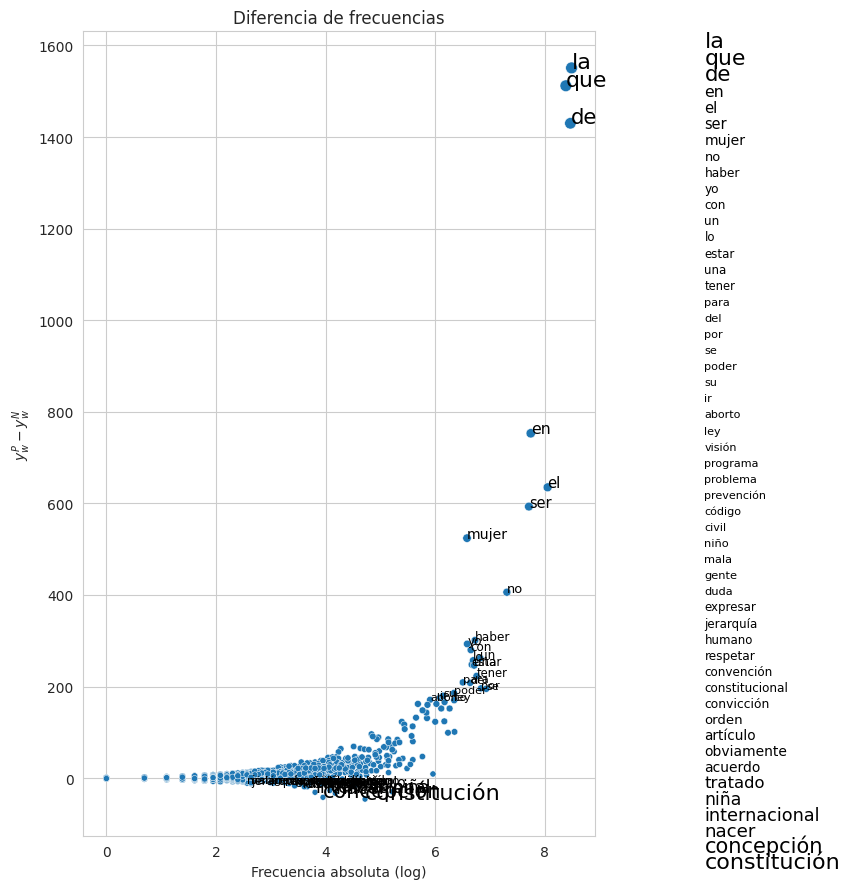

In [23]:
filename = os.path.join(FOLDER, "frecuencias.png")
plot_stats(count_diff, "Diferencia de frecuencias", "$y^{P}_{w}-y^{N}_{w}$", filename)

## Diferencia de proporciones

Se normalizan los vectores de palabras para reflejar las proporciones en lugar de su ocurrencia. La proporción observada se define como:

$$
f_{w}^{(i)} = y_{w}^{(i)} / n^{(i)}
$$

$$
f_{w}^{(P)}-f_{w}^{(N)}
$$

Esto se grafica contra la cantidad total de ocurrencias en escala logarítmica.

In [24]:
proportions = frequencies.div(frequencies.sum(axis=1), axis=0)
proportions_difference = proportions.loc["positivo"]-proportions.loc["negativo"]
proportions_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_difference,
        "pos": proportions.loc["positivo"],
        "neg": proportions.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.000016,0.000019,0.000035
1,abandonada,0.000000,0.000019,0.000019,0.000000
2,abandonado,0.000000,0.000019,0.000019,0.000000
3,abandonar,0.000000,-0.000035,0.000000,0.000035
4,abandono,0.000000,-0.000035,0.000000,0.000035


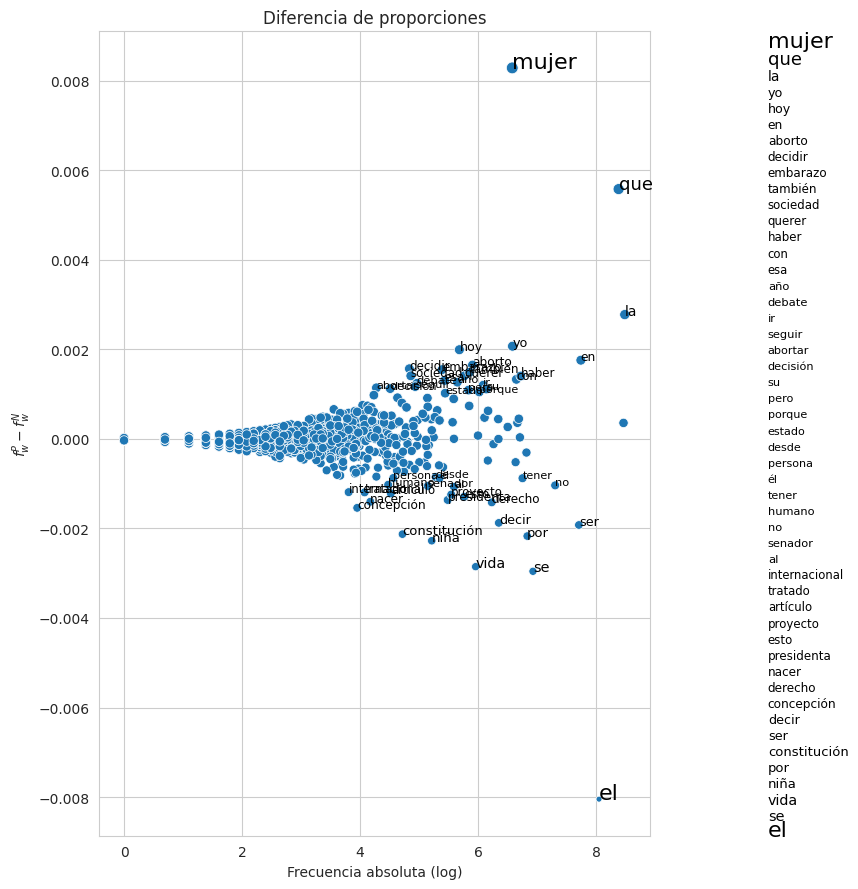

In [42]:
filename = os.path.join(FOLDER, "proporciones.png")
plot_stats(proportions_diff, "Diferencia de proporciones", "$f^{P}_{w}-f^{N}_{w}$", filename)

## Diferencia de proporciones sin stopwords

### Stopwrods de NLTK

In [49]:
nltk.download("stopwords")

from nltk.corpus import stopwords

stw = stopwords.words("spanish")
print(stw[:5])

['de', 'la', 'que', 'el', 'en']


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/macarena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
print(f"Cantidad de columnas (palabras) en el dataset: {len(frequencies.columns)}")
stop = len(sorted(set(frequencies.columns).intersection(set(stw))))
print(f"Cantidad de palabras stopwords en el dataset: {stop}")
non_stop = len(sorted(set(frequencies.columns).difference(set(stw))))
print(f"Cantidad de palabras no stopwords en el dataset: {non_stop}")

Cantidad de columnas (palabras) en el dataset: 4781
Cantidad de palabras stopwords en el dataset: 73
Cantidad de palabras no stopwords en el dataset: 4708


In [54]:
columns_wo_stw = sorted(set(frequencies.columns).difference(set(stw)))
frequencies_wo_stw = frequencies[columns_wo_stw]
frequencies_wo_stw.shape

(2, 4708)

In [55]:
proportions_wo_stw = frequencies_wo_stw.div(frequencies_wo_stw.sum(axis=1), axis=0)
proportions_wo_stw_difference = proportions_wo_stw.loc["positivo"]-proportions_wo_stw.loc["negativo"]
proportions_wo_stw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": proportions_wo_stw_difference,
        "pos": proportions_wo_stw.loc["positivo"],
        "neg": proportions_wo_stw.loc["negativo"]
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
proportions_wo_stw_diff.head()

,word,total,diff,pos,neg
0,abajo,0.693147,-0.000030,0.000035,0.000065
1,abandonada,0.000000,0.000035,0.000035,0.000000
2,abandonado,0.000000,0.000035,0.000035,0.000000
3,abandonar,0.000000,-0.000065,0.000000,0.000065
4,abandono,0.000000,-0.000065,0.000000,0.000065


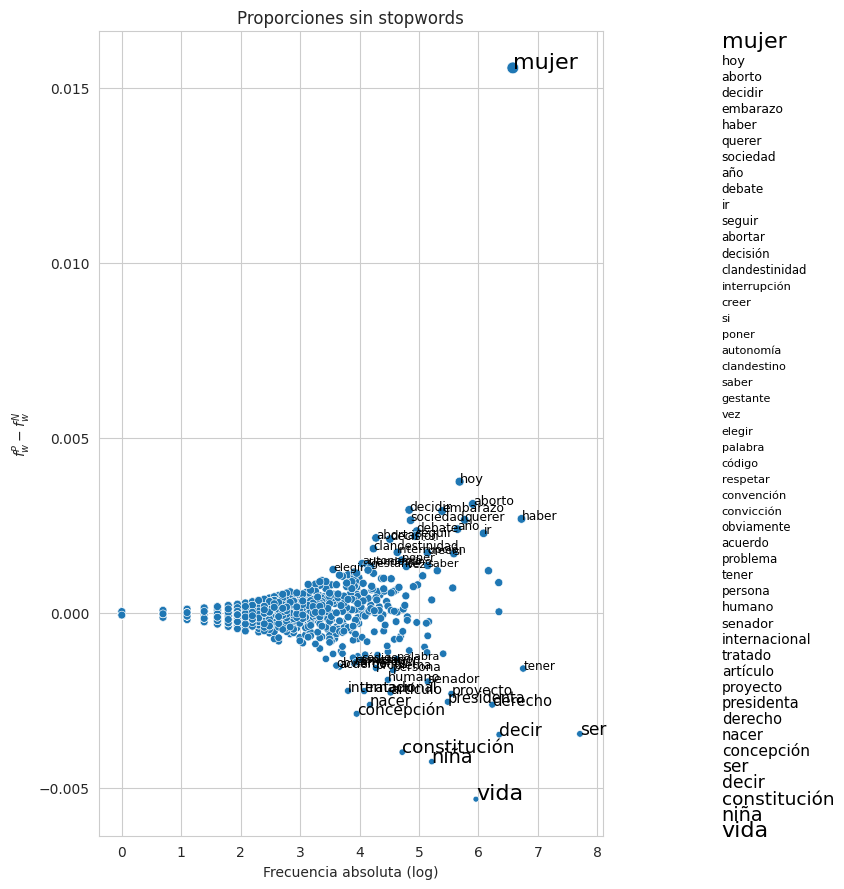

In [56]:
filename = os.path.join(FOLDER, "proporciones_sin_stopwords_nltk.png")
plot_stats(proportions_wo_stw_diff, "Proporciones sin stopwords", "$f^{P}_{w}-f^{N}_{w}$", filename)

### Stopwords por Ley de Zipf

## Odds

In [ ]:
odds_pos = proportions.loc["positivo"]/(1-proportions.loc["positivo"])
odds_neg = proportions.loc["negativo"]/(1-proportions.loc["negativo"])
odds_difference = odds_pos/odds_neg
odds_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": odds_difference,
        "pos": odds_pos,
        "neg": odds_neg
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
odds_diff.head()

In [ ]:
odds_diff["diff"].isin([math.inf, -math.inf]).sum()

In [ ]:
def postprocess_odds(row):
    infs = [math.inf, -math.inf]
    if (row.pos in infs) and (row.neg) in infs:
        if row.pos == row.neg:
            return 1
        else:
            return -1
    else:
        return row["diff"]

In [ ]:
odds_diff["diff"] = odds_diff.apply(lambda x: postprocess_odds(x), axis=1)
odds_diff

## Log-odds-ratio

In [ ]:
log_odds_diff = deepcopy(odds_diff)
log_odds_diff["diff"] = np.log(log_odds_diff["diff"])
log_odds_diff.head()

### Log-odds ratio suvizado

Agregar suavizado, pero cuidado: no se puede agregar peso sin más a una frecuencia (la suma ya no va a dar 1).

$$\widetilde{f}^{(i)} = f^{(i)} + \varepsilon$$

In [ ]:
smooth_log_odds_diff = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
smooth_log_odds_diff.head()

In [ ]:
# cantidad de palabras con frecuencia 0
(smooth_log_odds_diff[["pos", "neg"]]==0).sum(axis=0)

In [ ]:
smooth_log_odds_diff[["f_pos", "f_neg"]] = smooth_log_odds_diff[["pos", "neg"]].applymap(
    lambda x: x+0.5 if x == 0 else x
)
smooth_log_odds_diff.head()

In [ ]:
f_smooth_odds_pos = smooth_log_odds_diff["f_pos"]/(1-smooth_log_odds_diff["f_pos"])
f_smooth_odds_neg = smooth_log_odds_diff["f_neg"]/(1-smooth_log_odds_diff["f_neg"])
f_smooth_odds_difference = f_smooth_odds_pos/f_smooth_odds_neg
f_smooth_log_odds_diff = (
    pd
    .DataFrame({
        "word": smooth_log_odds_diff.word,
        "total": smooth_log_odds_diff.total,
        "diff": np.log(f_smooth_odds_difference),
        "pos": f_smooth_odds_pos,
        "neg": f_smooth_odds_pos
    })
)
f_smooth_log_odds_diff.head()

## Correction: elimating low-frequency words

In [ ]:
(
    pd.melt(
        proportions_diff[["word","pos","neg"]],
        id_vars=["word"],
        value_vars=["pos", "neg"],
    )
    .groupby("variable")["value"]
    .agg(
        min="min",
        q5=lambda x: np.percentile(x, q = 5),
        median="median",
        mean="mean",
        std="std",
        q95=lambda x: np.percentile(x, q = 95),
        max="max"
    )
)

In [ ]:
low_freq_df = deepcopy(proportions_diff[["word", "total", "pos", "neg"]])
low_freq_df.shape

In [ ]:
low_freq_df = low_freq_df[(0.000035<low_freq_df["neg"]) & (0.000019<low_freq_df["pos"])]
low_freq_df.shape

In [ ]:
low_freq_df[["pos", "neg"]].describe()

In [ ]:
high_freq_odds_pos = low_freq_df["pos"]/(1-low_freq_df["pos"])
high_freq_odds_neg = low_freq_df["neg"]/(1-low_freq_df["neg"])
high_freq_odds_difference = high_freq_odds_pos/high_freq_odds_neg
high_freq_log_odds_diff = (
    pd
    .DataFrame({
        "word": low_freq_df.word,
        "total": low_freq_df.total,
        "diff": np.log(high_freq_odds_difference),
        "pos": high_freq_odds_pos,
        "neg": high_freq_odds_neg
    })
    .reset_index(drop=True)
)
high_freq_log_odds_diff.head()

In [ ]:
perc = round(high_freq_log_odds_diff.shape[0] / proportions_diff.shape[0] * 100, 2)
print(f"Se persisten el {perc}% de los datos.")

## TF-IDF

In [ ]:
discourses = list(map(lambda x: set(x.split()),data.speech_lemmas.tolist()))
words = sorted(list(set(chain(*discourses))))

X = np.zeros((len(discourses), len(words)))

for i in range(len(words)):
    for j in range(len(discourses)):
        if words[i] in discourses[j]:
            X[j,i] += 1


In [ ]:
df = (
    pd.DataFrame(X, columns=words)
    .filter(frequencies.columns)
    .sum(axis=0)
    .to_frame()
    .rename(columns={0:"df"})
    .assign(
        idf=lambda x: 1/x,
        ln_idf=lambda x: x.idf.apply(lambda z: math.log(z))
    )
    .reset_index(names="word")
)
df.head()


In [ ]:
# al final uso df sin ln porque muchas palabras ocurren solo en un documento y eso
# hace que su peso termine siendo 0
tf_idf = (
    proportions
    .T
    .rename_axis("", axis=1)
    .reset_index(names="word")
    .merge(df, on="word")
    .assign(
        pos=lambda x: x.positivo/(x.df),
        neg=lambda x: x.negativo/(x.df)
    )
)
tf_idf.head()

In [ ]:
tfidf_diff = (
    pd
    .DataFrame({
        "word": tf_idf["word"],
        "diff": tf_idf["pos"]-tf_idf["neg"],
        "pos": tf_idf["pos"],
        "neg": tf_idf["neg"]
    })
    .merge(count_diff[["word", "total"]], on="word")
)
tfidf_diff.head()

In [ ]:
corr_prop = tfidf_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

## WordScores

In [ ]:
wkw = (
    (proportions.loc["positivo"]-proportions.loc["negativo"])/
    (proportions.loc["positivo"]+proportions.loc["negativo"])
)
nkw = frequencies.sum(axis=0) / frequencies.sum().sum()

wkw_diff = (
    pd
    .DataFrame({
        "total": count_total,
        "diff": wkw*nkw,
        "wkw": wkw,
        "nkw": nkw,
        "wnkw": wkw*nkw
    })
    .rename_axis("word", axis=0)
    .reset_index()
)
wkw_diff.head()

In [ ]:
corr_prop = wkw_diff["diff"].corr(proportions_diff["diff"])
print(f"Correlación con proporciones: {round(corr_prop,2)}")

## Visualizations

In [ ]:
stats = [
    odds_diff,
    log_odds_diff, f_smooth_log_odds_diff, high_freq_log_odds_diff,
    tfidf_diff, wkw_diff
]
titles = [
    "Odds",
    "Log-osdds-ratio", "Log-osdds-ratio suavizado",
    "Log-osdds-ratio suavizado (remoción de p. con baja frec.)",
    "TF-IDF", "WordScores"
]
y_labels = [
    "$O^{P}_{kw}/O^{N}_{kw}$", "$\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$",
    "smooth $\log{(O^{P}_{kw}/O^{N}_{kw})}$", "$tfidf^{P}_{kw}-tfidf^{N}_{kw}$",
    "$W^{*(D-R)}_{kw}$"
]

Observaciones:

- en freq. abs. casi no hay palabras negativas, esto puede ser porque:
  - los neg hablaron menos (personas)
  - los neg tienen discursos más breves
  - los neg no usaron palabras que se distingan de pos (en términos de freq. abs.)
  - ... seguir explorando